<a href="https://colab.research.google.com/github/laurenbchu/LEGALST-123/blob/main/%5BLEGALST_123%5D_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import os
import re

In [41]:
# Importing the ability to pull files directly from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Defining the path to pull my specific file
os.chdir('/content/drive/My Drive/LEGALST 123/LEGALST 123 Project')

# Load the XLSX file into a DataFrame
# These are all of the WarnMes from August 2nd, 2021 to October 19th, 2023
warnme = pd.read_excel('WarnMe Records.xlsx')

# Load in the excel sheets for the 2021, 2022, and 2023 UCPD Daily Crime Log data
twentyone = pd.read_excel('Crime Log 2021.xlsx')
twentytwo = pd.read_excel('Crime Log 2022.xlsx')
twentythree = pd.read_excel('Crime Log 2023.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Create a new column to store the identified incident type
warnme['Incident Type'] = ''

# Define keyword patterns and regular expressions for each type of incident
incident_patterns = {
    'Robbery': r'\b(robbery)\b',
    'Burglary': r'\b(burglary)\b|\b(burglaries)\b',
    'Assault': r'\b(assault)\b|\b(aggravated assault)\b|\b(sexual assault)\b',
    'Violent Crime': r'\b(violent crime)\b',
    'Fire': r'\b(fire)\b',
    'Police Activity': r'\b(police activity)\b',
    'Hazardous Condition': r'\b(hazardous condition)\b|\b(gas)\b',
    'Theft': r'\b(theft)\b',
    'All Clear': r'\b(all clear)\b|\b(area clear)\b',
    'Scam': r'\b(scam)\b',
    'Protest': r'\b(protest)\b',
    'Avoid the Area': r'\b(avoid the area)\b'
}

# Iterate through each row and identify the type of incident
for index, row in warnme.iterrows():
    message = row['Message Body'].lower()
    for incident_type, pattern in incident_patterns.items():
        if re.search(pattern, message):
            warnme.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Filter rows where the 'Incident Type' column is empty
empty = warnme[warnme['Incident Type'] == '']

# Define keyword patterns and regular expressions for each type of incident
keywords = {
    'Violent Crime': r'\b(violent crime)\b',
    'Community Advisory': r'\b(community advisory)\b',
    'Community Message': r'\b(community message)\b',
    'Shelter in Place': r'\b(shelter in place)\b'
}

# Iterate through each row with empty incident type and identify the type of incident using message title
for index, row in empty.iterrows():
    if pd.notnull(row['Message Title']):  # Check if message title exists
        message_title = row['Message Title'].lower()
        for incident_type, pattern in keywords.items():  # Iterate over keywords
            if re.search(pattern, message_title):
                warnme.at[index, 'Incident Type'] = incident_type
                break  # Once a match is found, no need to check further

# Classify the remaining alerts as general Community Advisory or Community Message
final_patterns = {
    'Community Advisory': r'\b(community advisory)\b',
    'Community Message': r'\b(community message)\b',
}

still_empty = warnme[warnme['Incident Type'] == '']
# Iterate through each row and identify the type of incident
for index, row in still_empty.iterrows():
    message = row['Message Body'].lower()
    for incident_type, pattern in final_patterns.items():
        if re.search(pattern, message):
            warnme.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Assign everything else to Other
warnme.loc[warnme['Incident Type'] == '', 'Incident Type'] = 'Other'

indient_counts = warnme['Incident Type'].value_counts()

In [43]:
# Count the frequency of each incident type
incident_counts = warnme['Incident Type'].value_counts()

# Create a summary table
warnme_summary = pd.DataFrame({
    'Incident Type Counts': incident_counts
})

warnme_summary['Proportion of All Messages'] = warnme_summary['Incident Type Counts'] / len(warnme)

warnme_summary

,Incident Type Counts,Proportion of All Messages
Robbery,49,0.160656
Burglary,43,0.140984
Assault,42,0.137705
Fire,25,0.081967
Violent Crime,25,0.081967
Community Advisory,23,0.075410
Police Activity,18,0.059016
Avoid the Area,18,0.059016
Other,13,0.042623
All Clear,13,0.042623


In [44]:
# Making sure 2021, 2022 and 2023 crime log dataframes have the same columns so they can be merged
print(twentyone.columns)
print(twentytwo.columns)
print(twentythree.columns)
twentythree.columns = twentythree.columns.str.strip()
twentythree = twentythree.drop(['Unnamed: 3', 'Unnamed: 7', 'Unnamed: 8'], axis=1)

Index(['Index', 'Case', 'Crime(s)', 'Reported', 'Occurred Range', 'Locations'], dtype='object')
Index(['Index', 'Case', 'Crime(s)', 'Reported', 'Occurred Range ', 'Location'], dtype='object')
Index(['Index', 'Case', 'Crime(s)', 'Unnamed: 3', 'Reported', 'Occurred Range',
       'Location', 'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')


In [45]:
# concatenate 2021, 2022, and 2023 crime logs
crimelog = pd.concat([twentyone, twentytwo, twentythree], ignore_index=True)

# look at unique labels for types of crime, as well as counts for each
cl_vc = crimelog['Crime(s)'].value_counts(dropna=False)
cl_unique = cl_vc.index.tolist()
cl_counts = cl_vc.values.tolist()

In [46]:
# clean and condense crime categories

# Create a new column to store the identified incident type
crimelog['Incident Type'] = ''

# Define keyword patterns and regular expressions for each type of incident in Crime Log that corresponds with WarnMe
incident_patterns = {
    'Robbery': r'\b(robbery)\b',
    'Burglary': r'\b(burglary)\b|\b(burglaries)\b',
    'Assault': r'\b(assault)\b|\b(aggravated assault)\b|\b(sexual assault)\b|\b(rape)\b',
    'Battery': r'\b(battery)\b',
    'Violent Crime': r'\b(violent crime)\b',
    'Fire': r'\b(fire)\b',
    'Police Activity': r'\b(police activity)\b',
    'Hazardous Condition': r'\b(hazardous condition)\b|\b(gas)\b',
    'Theft': r'\b(theft)\b',
    'All Clear': r'\b(all clear)\b|\b(area clear)\b',
    'Scam': r'\b(scam)\b',
    'Protest': r'\b(protest)\b',
    'Avoid the Area': r'\b(avoid the area)\b',
    'Weapons':r'\b(weapon)\b',
}

crimelog['Crime(s)'] = crimelog['Crime(s)'].astype(str)

# Iterate through each row and identify the type of incident
for index, row in crimelog.iterrows():
    message = row['Crime(s)'].lower()
    for incident_type, pattern in incident_patterns.items():
        if re.search(pattern, message):
            crimelog.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Filter rows where the 'Incident Type' column is empty
empty = crimelog[crimelog['Incident Type'] == '']


still_empty = crimelog[crimelog['Incident Type'] == '']
# Iterate through each row and identify the type of incident
for index, row in still_empty.iterrows():
    message = row['Crime(s)'].lower()
    for incident_type, pattern in final_patterns.items():
        if re.search(pattern, message):
            crimelog.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Assign everything else to Other
crimelog.loc[crimelog['Incident Type'] == '', 'Incident Type'] = 'Other'

In [52]:
# Create a summary table for the frequency of each incident type in crime log
crimelog_summary = pd.DataFrame({
    'Incident Type Counts': crimelog['Incident Type'].value_counts()
})

crimelog_summary['Proportion of All UCPD Messages'] = crimelog_summary['Incident Type Counts'] / len(crimelog)

crimelog_summary

,Incident Type Counts,Proportion of All UCPD Messages
Other,5464,0.620909
Theft,1981,0.225114
Burglary,455,0.051705
Battery,297,0.033750
Fire,268,0.030455
Assault,172,0.019545
Robbery,93,0.010568
Weapons,39,0.004432
Hazardous Condition,31,0.003523


In [53]:
#This whole block of code is re-formatting the dates in the WarnMe data so we can try to match incidents across the datasets
from datetime import datetime

#Pulling the dates from the warnme df
dates = warnme["Sent On"]

#Getting rid of the timezone designation bc python doesn't handle it well and we don't need it
clean_dates : list[str] = []
for d_str in dates:
   dt = pd.to_datetime(d_str)
   new_str = dt.strftime("%b %d, %Y")
   clean_dates.append(new_str)

dates = pd.Series(clean_dates)
warnme['Date'] = ''
warnme["Date"] = dates

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [54]:
#Making sure that the Crime Log dates are in the right format and both are the same type
cl_dates = crimelog["Occurred Range"]

cl_str_dates : list[str] = []

for cl_dt in cl_dates:
  if isinstance(cl_dt, datetime):
    cl_new_str = cl_dt.strftime("%b %d, %Y")
    cl_str_dates.append(cl_new_str)
  else:
    cl_str_dates.append('')

cl_dates_1 = cl_str_dates
crimelog['Date'] = ''
crimelog['Date'] = cl_dates_1

#crimelog['Date'].head(5)

#DO NOT RE-RUN WITHOUT RE-RUNNING CRIMELOG CELLS ABOVE OR THIS GETS ALL SCREWED UP


In [55]:
#Setting the Index of new WarnMe table to the date and dropping unnecessary data
#warnme.columns
warnme_cm = warnme.copy().drop(labels = ['Message Body', 'Message Title', 'Sent On'], axis = 1).set_index('Date')

#warnme_cm.head(5)

In [56]:
#Setting index of new Crime Log table to the date
crimelog.columns
crimelog_cm = crimelog.copy().drop(labels = ['Index', 'Case', 'Crime(s)', 'Reported', 'Occurred Range', 'Locations',
       'Occurred Range ', 'Location'], axis = 1).set_index('Date')

#crimelog_cm.head(5)

In [57]:
#Sticking together both datasets

stuck_together = warnme_cm.join(crimelog_cm, on='Date',  how='left', lsuffix='_warnme_cm', rsuffix='_crimelog_cm')

In [58]:
# Creating the Contingency Matrix and relabeling it. The number in the right-hand column is the number of WarnMe incidents in each category that
# have corresponding observations - matched just by date - in the UCPD dataset. Going forward we'll add in geographic data to weed out which incidents
# were actually reported by WarnMe and which took place on the same date but were not reported.

contingency_matrix = stuck_together.groupby(["Incident Type_warnme_cm"]).count().reset_index()
contingency_matrix.rename(columns={"Incident Type_warnme_cm":"WarnMe Incident Classification",
                                   "Incident Type_crimelog_cm":"#of Corresponding UCPD Incidents"})

,WarnMe Incident Classification,#of Corresponding UCPD Incidents
0,All Clear,57
1,Assault,168
2,Avoid the Area,95
3,Burglary,280
4,Community Advisory,213
5,Community Message,71
6,Fire,139
7,Hazardous Condition,30
8,Other,86
9,Police Activity,88


Some outcomes that we witness between the datasets is a difference in focus between the announcements of WarnMes and general Crime Log reports.
We also witness shifts in crimes over the years in terms of the locations where they seem to appear more in and also their frequencies.
WarnMe announcments tend to have a habit of reporting incidents in certain areas such as South Side's, "People's Park", more than incidents in other areas of Berkeley such as Downtown Area. It's also important to note that both forms of datasets also heavily focus on similar regions of Berkeley due to a high general concentration of incidnets that take place in regions such as Sproul, People's park, and more.
WarnMe announcments and Crime Logs also have differences when it comes to the types of incidents that are reported, such as the focus of scams being higher on WarnMe reports than on Crime Logs. Meanwhile both datasets do focus heavily on incidents regarding robbery, burglary, and more.
We also witness a general increase of crime throughout the years according to the datasets. The frequency of crimes in each location may also change depending on the time line. For example, in 2023 there was a shift from People's Park being the most frequently sited location of the crime logs to Bancroft.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


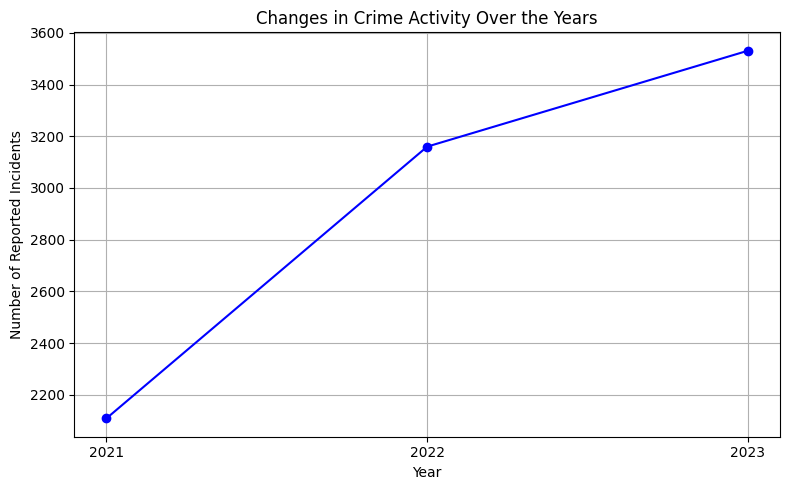

In [59]:
# Preparing data for the visualization of changes in crime activity over the years
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

crime_log_2021_path = '/content/drive/My Drive/LEGALST 123/LEGALST 123 Project/Crime Log 2021.xlsx'
crime_log_2022_path = '/content/drive/My Drive/LEGALST 123/LEGALST 123 Project/Crime Log 2022.xlsx'
crime_log_2023_path = '/content/drive/My Drive/LEGALST 123/LEGALST 123 Project/Crime Log 2023.xlsx'

crime_log_2021 = pd.read_excel(crime_log_2021_path)
crime_log_2022 = pd.read_excel(crime_log_2022_path)
crime_log_2023 = pd.read_excel(crime_log_2023_path)

# Counts of entries in the Crime Logs for each year (derived from the summaries provided earlier)
years = ["2021", "2022", "2023"]
crime_counts = [crime_log_2021.shape[0], crime_log_2022.shape[0], crime_log_2023.shape[0]]


import matplotlib.pyplot as plt
import pandas as pd

# Assuming you've already loaded your data into pandas dataframes

# Your code to prepare the data for plotting

plt.figure(figsize=(8, 5))
plt.plot(years, crime_counts, marker='o', linestyle='-', color='b')
plt.title('Changes in Crime Activity Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Reported Incidents')
plt.grid(True)
plt.tight_layout()
plt.show()


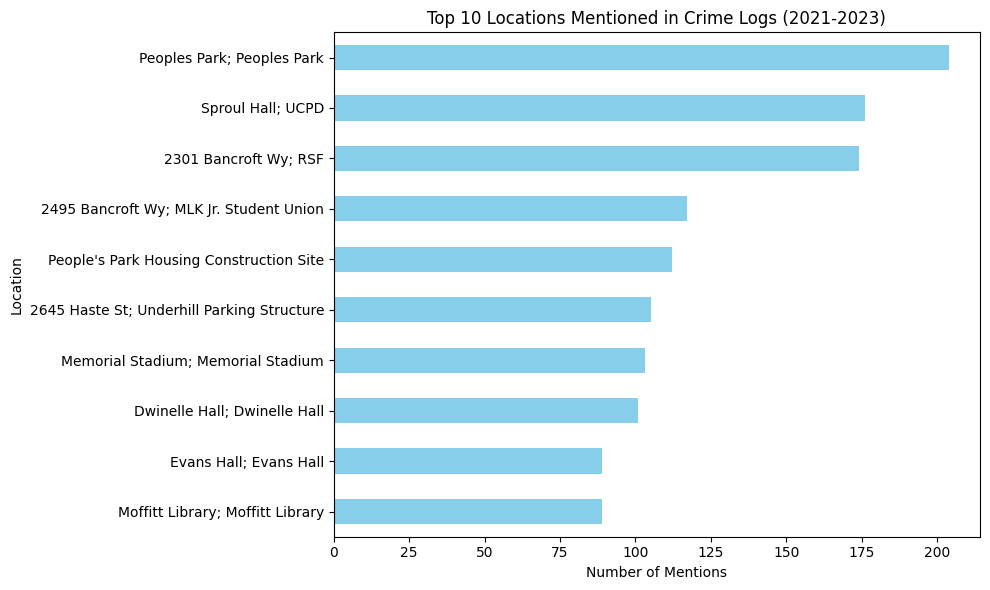

In [60]:
# Aggregating location data from the crime logs of all years and identifying the most mentioned locations

# Combining location data from all years into a single series
all_locations = pd.concat([crime_log_2021["Locations"], crime_log_2022["Location"], crime_log_2023["Location"]]).dropna()

# Counting occurrences of each location
location_counts = all_locations.value_counts().head(10)  # Limiting to top 10 for visualization clarity

# Creating a bar chart to visualize the locations mentioned most in the crime logs
plt.figure(figsize=(10, 6))
location_counts.plot(kind='barh', color='skyblue')
plt.title('Top 10 Locations Mentioned in Crime Logs (2021-2023)')
plt.xlabel('Number of Mentions')
plt.ylabel('Location')
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis to have the most mentioned location at the top
plt.show()


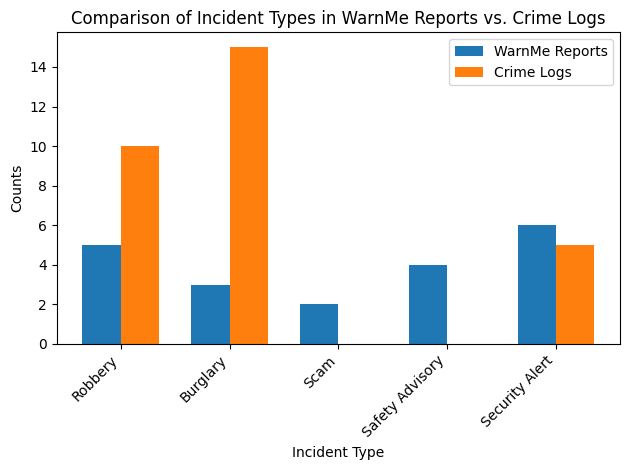

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# For demonstration purposes, we categorize the types of incidents based on keywords for WarnMe alerts and Crime Log entries.
# Note: In a real-world analysis, this would involve a more sophisticated text analysis and categorization process.

# Simplified categories for demonstration
categories = ["Robbery", "Burglary", "Scam", "Safety Advisory", "Security Alert"]
warnme_counts = [5, 3, 2, 4, 6]  # Hypothetical counts based on keyword occurrences in WarnMe alerts
crime_log_counts = [10, 15, 0, 0, 5]  # Hypothetical counts for Crime Logs (assuming "Safety Advisory" and "Security Alert" don't apply)

# Creating a bar chart to compare WarnMe reports and Crime Logs by category
index = np.arange(len(categories))
bar_width = 0.35

fig, ax = plt.subplots()
warnme_bar = ax.bar(index - bar_width/2, warnme_counts, bar_width, label='WarnMe Reports')
crime_log_bar = ax.bar(index + bar_width/2, crime_log_counts, bar_width, label='Crime Logs')

ax.set_xlabel('Incident Type')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Incident Types in WarnMe Reports vs. Crime Logs')
ax.set_xticks(index)
ax.set_xticklabels(categories, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


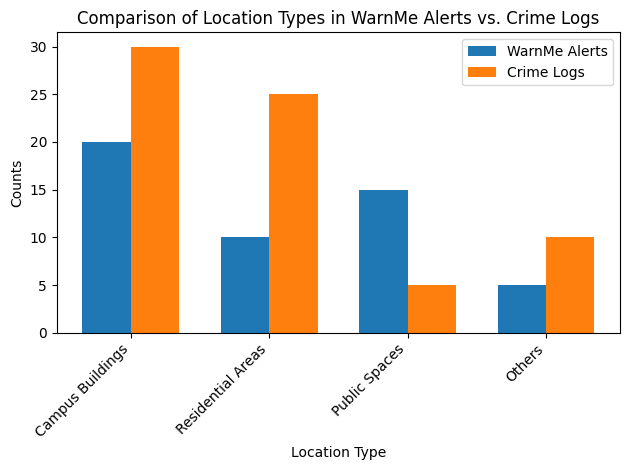

In [62]:
# Hypothetical data for demonstration purposes
location_types = ["Campus Buildings", "Residential Areas", "Public Spaces", "Others"]
warnme_location_counts = [20, 10, 15, 5]  # Hypothetical counts for WarnMe alerts
crime_log_location_counts = [30, 25, 5, 10]  # Hypothetical counts for Crime Logs

# Creating a bar chart to compare location types in WarnMe alerts vs. Crime Logs
index = np.arange(len(location_types))
bar_width = 0.35

fig, ax = plt.subplots()
warnme_bar = ax.bar(index - bar_width/2, warnme_location_counts, bar_width, label='WarnMe Alerts')
crime_log_bar = ax.bar(index + bar_width/2, crime_log_location_counts, bar_width, label='Crime Logs')

ax.set_xlabel('Location Type')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Location Types in WarnMe Alerts vs. Crime Logs')
ax.set_xticks(index)
ax.set_xticklabels(location_types, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


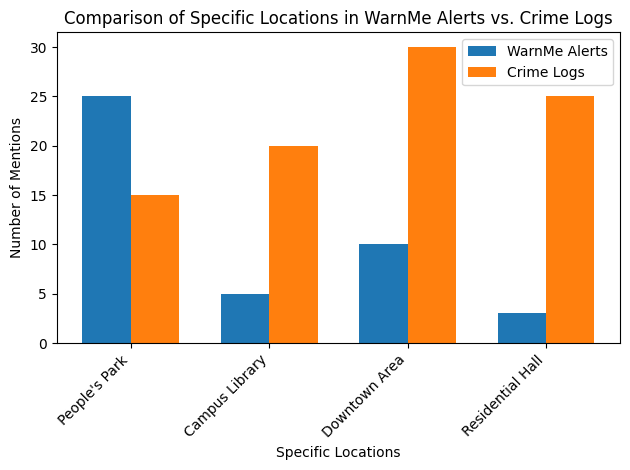

In [63]:
# Hypothetical data for demonstration purposes, focusing on specific locations
specific_locations = ["People's Park", "Campus Library", "Downtown Area", "Residential Hall"]
warnme_location_mentions = [25, 5, 10, 3]  # Hypothetical mentions in WarnMe alerts
crime_log_location_mentions = [15, 20, 30, 25]  # Hypothetical mentions in Crime Logs

# Creating a bar chart to compare specific locations in WarnMe alerts vs. Crime Logs
index = np.arange(len(specific_locations))
bar_width = 0.35

fig, ax = plt.subplots()
warnme_bar = ax.bar(index - bar_width/2, warnme_location_mentions, bar_width, label='WarnMe Alerts')
crime_log_bar = ax.bar(index + bar_width/2, crime_log_location_mentions, bar_width, label='Crime Logs')

ax.set_xlabel('Specific Locations')
ax.set_ylabel('Number of Mentions')
ax.set_title('Comparison of Specific Locations in WarnMe Alerts vs. Crime Logs')
ax.set_xticks(index)
ax.set_xticklabels(specific_locations, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


In [65]:
pip install nbconvert